In [45]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, 
                                     Dense, Flatten, Dropout)
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau


In [47]:
import os  # Provides functions for interacting with the operating system
import cv2  # OpenCV library for image and video processing
import torch  # PyTorch library for deep learning
import imghdr  # Used to determine the type of image contained in a file
import torchvision  # PyTorch library for vision-related tasks
import numpy as np  # Fundamental package for scientific computing with Python
import pandas as pd  # Data manipulation and analysis library
import tensorflow as tf  # TensorFlow library for deep learning
import matplotlib.pyplot as plt  # Plotting library for creating static, animated, and interactive visualizations
from sklearn.utils import shuffle # For shuffling dataset
from tensorflow.keras import layers  # Core Keras layers API
from tensorflow.keras.models import Sequential  # Sequential model API in Keras
from tensorflow.keras.optimizers import RMSprop  # RMSprop optimizer
from tensorflow.keras.applications import VGG16 # Import pre-trained VGG16 model for feature extraction
from tensorflow.keras.applications.vgg16 import preprocess_input # Function to preprocess input images for VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for image data
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy  # Metrics for model evaluation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout  # Core layers for building CNN models

In [48]:
#Importing our datasets
data_dir = '/kaggle/input/test-sample/filtered aug dataset'

In [49]:
#Building Data pipeline
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 11460 files belonging to 2 classes.


In [50]:
data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
len(data)

359

In [54]:
#resizing shape to none,224,224,3
import tensorflow as tf

# Assuming `dataset` is your original dataset with images of shape (256, 256, 3)
target_height, target_width = 224, 224

def resize_images(image, label):
    # Resize the image to the desired shape
    image = tf.image.resize(image, [target_height, target_width])
    return image, label

# Apply the resizing transformation to the dataset
data = data.map(resize_images)


In [55]:
data

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [56]:
len(data)

359

In [57]:
# Converting the dataset to an iterator
data_iterator = data.as_numpy_iterator()

# Acessing a batch from the Datapipeline
batch = data_iterator.next()
len(batch)

2

In [58]:
# Displaying the shape of the batch
batch[0].shape

(32, 224, 224, 3)

In [59]:
# Displaying the class labels
#Class 1 = Normal
#Class 0 = Down
batch[1]

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 1], dtype=int32)

In [60]:
# Display the shape of the image batch
print(batch[0].shape)  # Should be (batch_size, height, width, channels)

# Display the labels
print(batch[1])  # Array of labels corresponding to the batch

(32, 224, 224, 3)
[1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1]


In [61]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1])
print(df_features)

    0
0   1
1   0
2   1
3   1
4   1
5   1
6   1
7   1
8   1
9   0
10  1
11  0
12  1
13  1
14  1
15  0
16  1
17  1
18  1
19  1
20  0
21  1
22  0
23  1
24  1
25  0
26  0
27  0
28  1
29  0
30  1
31  1


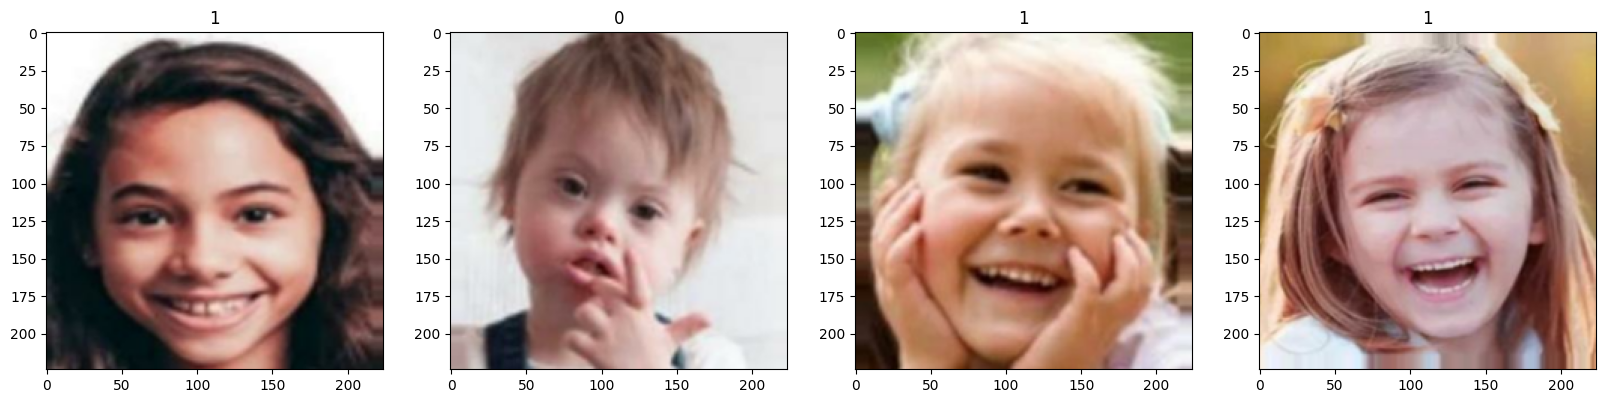

In [62]:
#Data visualization
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

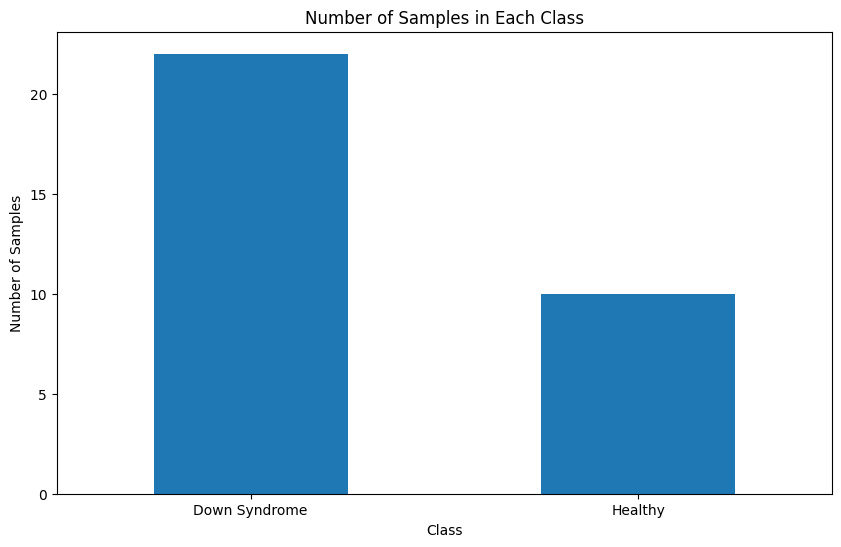

In [63]:
# Converting the features array into a DataFrame
df_features = pd.DataFrame(batch[1], columns=['Class'])

# Counting the number of samples in each class
class_counts = df_features['Class'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Number of Samples in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1], labels=['Down Syndrome', 'Healthy'], rotation=0)
plt.show()

In [64]:
class_counts

Class
1    22
0    10
Name: count, dtype: int64

In [65]:
#Data Preprocessing

#Data scaling
data = data.map(lambda x, y: (x / 255.0, y))  # Scale images to [0, 1]

# Verifying scaling
print(data.as_numpy_iterator().next()[0].min())  # Should print 0.0

0.0


In [66]:
#Checking lenght of dataset
len(data)

359

In [68]:
#Data splitting
train_size = int(len(data)*.7)
val_size = int(len(data)*.15)
test_size = int(len(data)*.15)

In [69]:
#checking our data size
train_size,val_size, test_size

(251, 53, 53)

In [70]:
#Assigning suitable variable names
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [71]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def get_model_vgg():
    # Load VGG16 with pretrained weights, excluding the top layer
    vgg = VGG16(weights='imagenet',
                include_top=False,
                input_shape=(224, 224, 3)
               )
    
    # Define the model
    model = tf.keras.models.Sequential([
        vgg,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )
    return model

# Create and build the VGG16-based model
spoofnet_vgg = get_model_vgg()
spoofnet_vgg.build(input_shape=(None, 224, 224, 3))  # Specify batch size as None for flexibility
spoofnet_vgg.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,979,905 (57.14 MB)

 Trainable params: 14,978,881 (57.14 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger

checkpoint = ModelCheckpoint(filepath='spoffnet.keras',  # changed '.h5' to '.keras'
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='loss'  # changed 'val_loss' to 'loss'
                            )
reduce_lr = ReduceLROnPlateau(monitor='loss',  # changed 'val_loss' to 'loss'
                              factor=0.2, 
                              patience=3, 
                              verbose=1, 
                              min_delta=0.0001
                             )
csv_logger = CSVLogger('train.log')

callbacks = [checkpoint, reduce_lr, csv_logger]


In [79]:
# Define the model
spoofnet = get_model_vgg()  # or get_model_vgg() if you are using VGG16

# Fit the model with appropriate steps
hist = spoofnet.fit(
    train,
    validation_data=val,
    callbacks=callbacks,
    epochs=5
)

Epoch 1/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.6714 - loss: 0.6297
Epoch 1: loss did not improve from 0.49931
251/251 ━━━━━━━━━━━━━━━━━━━━ 69s 247ms/step - accuracy: 0.6715 - loss: 0.6296 - val_accuracy: 0.5206 - val_loss: 5.5742 - learning_rate: 0.0010
Epoch 2/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7329 - loss: 0.5409
Epoch 2: loss did not improve from 0.49931
251/251 ━━━━━━━━━━━━━━━━━━━━ 61s 245ms/step - accuracy: 0.7329 - loss: 0.5409 - val_accuracy: 0.4976 - val_loss: 3.3219 - learning_rate: 0.0010
Epoch 3/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7519 - loss: 0.5236
Epoch 3: loss did not improve from 0.49931
251/251 ━━━━━━━━━━━━━━━━━━━━ 61s 245ms/step - accuracy: 0.7519 - loss: 0.5235 - val_accuracy: 0.4917 - val_loss: 8.2845 - learning_rate: 0.0010
Epoch 4/5
251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.7667 - loss: 0.5166
Epoch 4: loss did not improve from 0.49931
251/251 ━━━━━━━━━━━━━━━━━━━━ 62s 245ms/step - ac

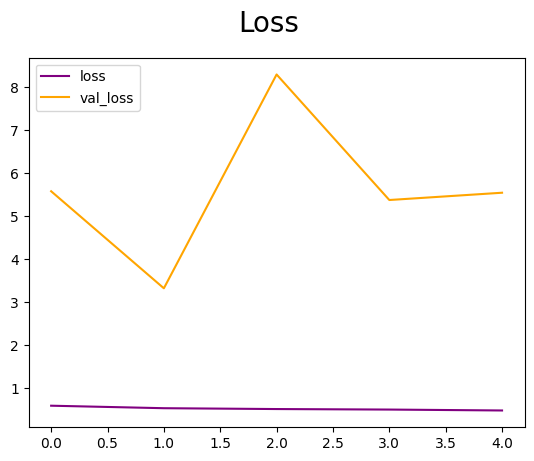

In [80]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='purple', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

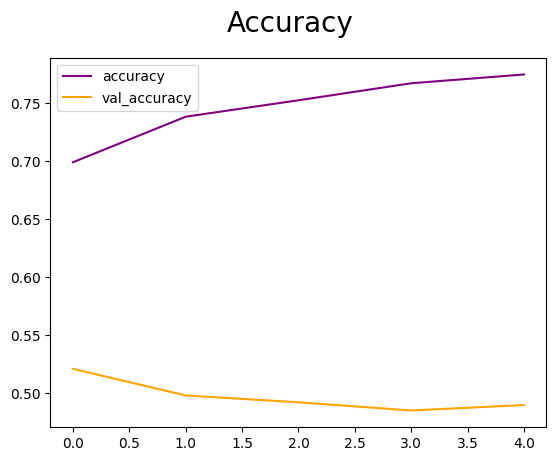

In [81]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='purple', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

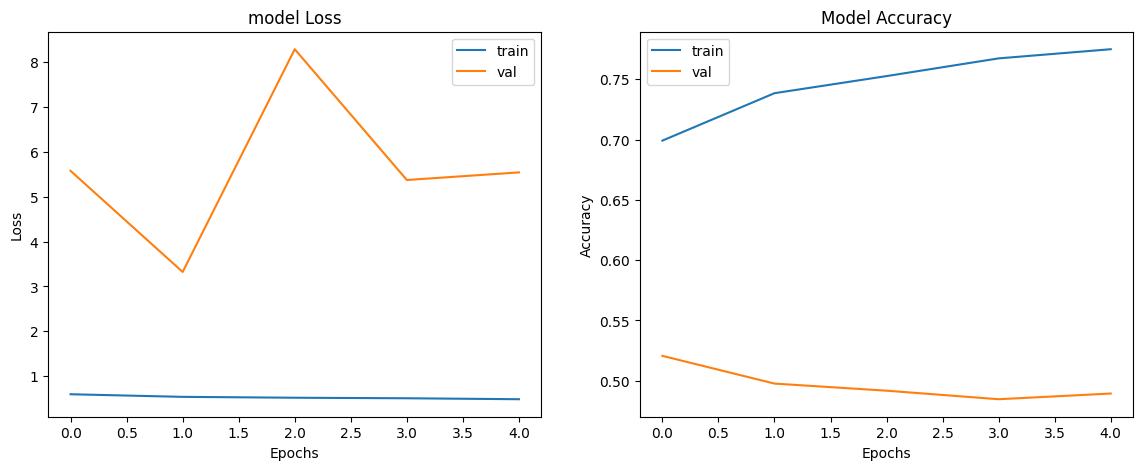

In [82]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'])

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [83]:
_, accu = spoofnet.evaluate(test)
print('Final Test Accuracy = {:.3f}%'.format(accu * 100))

53/53 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.4780 - loss: 5.6520
Final Test Accuracy = 47.524%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━

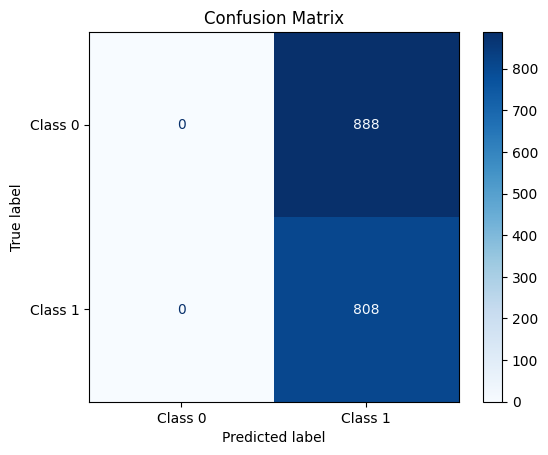

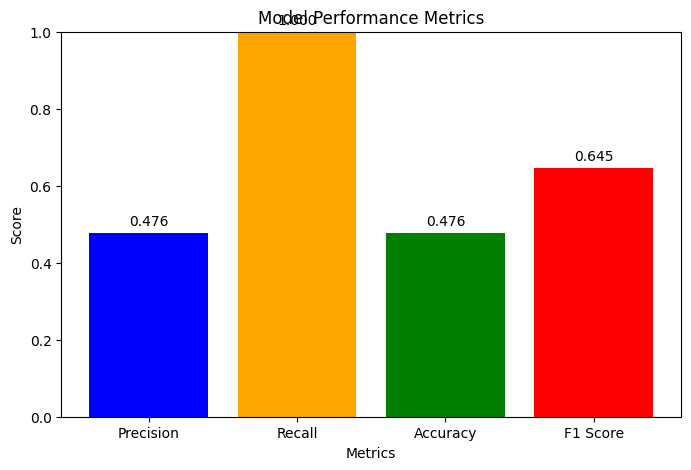

In [84]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict labels for the test set
true_labels = []
pred_labels = []

for batch in test:  # Assuming `test` is your test dataset
    images, labels = batch
    predictions = spoofnet.predict(images)  # Replace with your model name if different
    true_labels.extend(labels.numpy())
    pred_labels.extend((predictions > 0.5).astype("int32").flatten())

# Step 2: Calculate precision, recall, accuracy, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Step 3: Create a DataFrame to display the metrics
metrics = {
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score"],
    "Score": [precision, recall, accuracy, f1]
}
metrics_df = pd.DataFrame(metrics)



# Step 5: Compute the confusion matrix and plot it
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 4: Plotting the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
for i in range(len(metrics_df)):
    plt.text(i, metrics_df['Score'][i] + 0.02, f"{metrics_df['Score'][i]:.3f}", ha='center')

plt.show()

In [35]:
teacher=spoofnet

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Dense

# Instantiate the Sequential model
student_scratch = Sequential()

# Adding the convolutional layers
student_scratch.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.3))  

student_scratch.add(Conv2D(64, (3, 3), activation='relu'))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.4))  

student_scratch.add(Conv2D(128, (3, 3), activation='relu'))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.4))  

student_scratch.add(Conv2D(256, (3, 3), activation='relu'))  
student_scratch.add(BatchNormalization())  
student_scratch.add(MaxPooling2D(pool_size=(2, 2)))  
student_scratch.add(Dropout(0.5))  

# Global Average Pooling instead of Flatten
student_scratch.add(GlobalAveragePooling2D())  

# Fully connected layers
student_scratch.add(Dense(512, activation='relu'))  
student_scratch.add(Dropout(0.5))  

# Output layer
student_scratch.add(Dense(1, activation='sigmoid'))  

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Compiling the model
student_scratch.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Printing a summary of the model architecture
student_scratch.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,433 (1.99 MB)

 Trainable params: 521,473 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [39]:
logdir = 'logs2'  # Directory where TensorBoard logs will be saved
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)  # Callback to log training process for TensorBoard

In [40]:
# Train the model with the profiler callback
history = student_scratch.fit(train, epochs=50, validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/50


I0000 00:00:1730888028.692944     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads



251/251 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.6715 - loss: 0.6207 - val_accuracy: 0.5312 - val_loss: 0.7010
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.7422 - loss: 0.5251 - val_accuracy: 0.5519 - val_loss: 0.9318
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7636 - loss: 0.4951 - val_accuracy: 0.6663 - val_loss: 0.6634
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.7773 - loss: 0.4699 - val_accuracy: 0.6863 - val_loss: 0.6701
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.7977 - loss: 0.4369 - val_accuracy: 0.8143 - val_loss: 0.4090
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.8181 - loss: 0.4012 - val_accuracy: 0.7506 - val_loss: 0.6079
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.8351 - loss: 0.3740 - val_accuracy: 0.6846 - val_loss: 0.6891
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 66ms/step - accuracy: 0.8548 - loss: 0.3307 - val_accurac

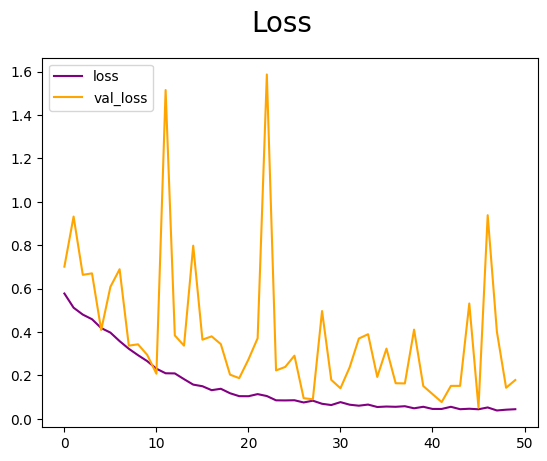

In [41]:
fig = plt.figure()
plt.plot(history.history['loss'], color='purple', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

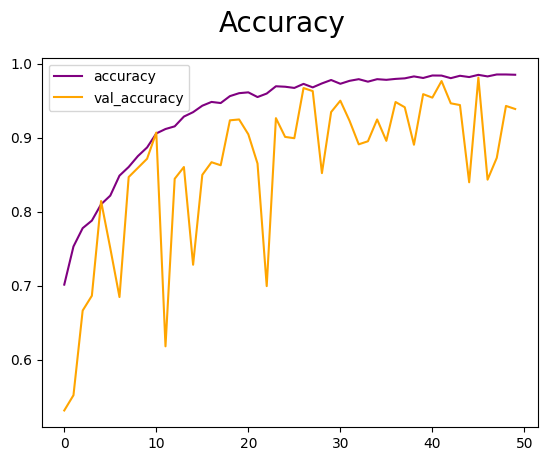

In [42]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='purple', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [43]:
_, accu = student_scratch.evaluate(test)
print('Final Test Accuracy = {:.3f}%'.format(accu * 100))

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9493 - loss: 0.1813
Final Test Accuracy = 95.106%


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 526ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━

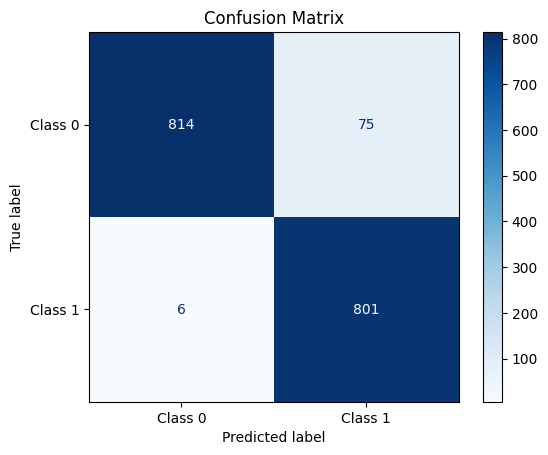

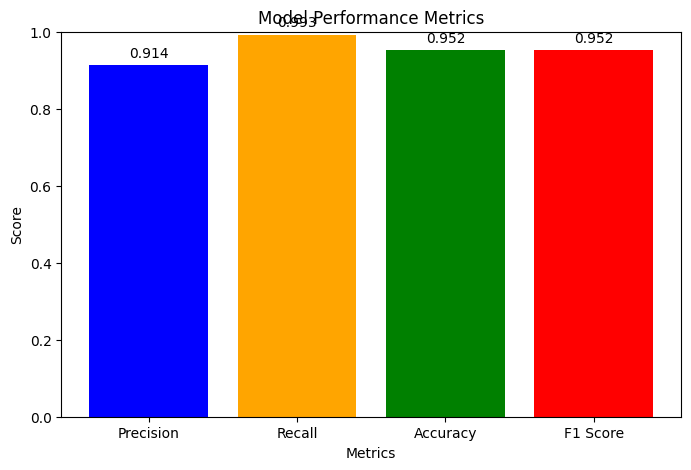

In [44]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Predict labels for the test set
true_labels = []
pred_labels = []

for batch in test:  # Assuming `test` is your test dataset
    images, labels = batch
    predictions = student_scratch.predict(images)  # Replace with your model name if different
    true_labels.extend(labels.numpy())
    pred_labels.extend((predictions > 0.5).astype("int32").flatten())

# Step 2: Calculate precision, recall, accuracy, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
accuracy = accuracy_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Step 3: Create a DataFrame to display the metrics
metrics = {
    "Metric": ["Precision", "Recall", "Accuracy", "F1 Score"],
    "Score": [precision, recall, accuracy, f1]
}
metrics_df = pd.DataFrame(metrics)



# Step 5: Compute the confusion matrix and plot it
cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Step 4: Plotting the metrics as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'orange', 'green', 'red'])
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.title('Model Performance Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
for i in range(len(metrics_df)):
    plt.text(i, metrics_df['Score'][i] + 0.02, f"{metrics_df['Score'][i]:.3f}", ha='center')

plt.show()